## Task 1: Spark SQL Mechanics

In [215]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

vocabulary_size = 500
global_truncate = True

#Create a SparkSession
spark = SparkSession.builder \
    .appName('app_name') \
    .master('local[*]') \
    .config('spark.sql.execution.arrow.pyspark.enabled', True) \
    .config('spark.sql.session.timeZone', 'UTC') \
    .config('spark.driver.memory','16g') \
    .config("spark.executor.memory", "16g") \
    .config('spark.ui.showConsoleProgress', True) \
    .config('spark.sql.repl.eagerEval.enabled', True) \
    .getOrCreate()

In [216]:
from pyspark.sql.functions import when, col
# Load the data into a dataframe
df_test = spark.read.format("csv") \
                            .option("header", "true") \
                            .load("test.csv")

# Load in training data into a dataframe
df_train = spark.read.format("csv") \
                            .option("header", "true") \
                            .load("train.csv")

df_train = df_train.withColumn('author_short', col('author')).withColumn('author', when(col('author') == 'EAP', "Eadgar Allan Poe")
                                 .when(col('author') == 'HPL', "H.P. Lovecraft")
                                 .otherwise('Mary Shelley'))

# The above print reveals that parsing the CSV has caught some unwated lines of text.
# We can select rows based on the only three available authors to clean up the dataset.

In [217]:
df_train.createOrReplaceTempView("train")
df_test.createOrReplaceTempView("test")

result = spark.sql("SELECT author, author_short FROM train")
result.show()

+----------------+------------+
|          author|author_short|
+----------------+------------+
|Eadgar Allan Poe|         EAP|
|  H.P. Lovecraft|         HPL|
|Eadgar Allan Poe|         EAP|
|    Mary Shelley|         MWS|
|  H.P. Lovecraft|         HPL|
|    Mary Shelley|         MWS|
|Eadgar Allan Poe|         EAP|
|Eadgar Allan Poe|         EAP|
|Eadgar Allan Poe|         EAP|
|    Mary Shelley|         MWS|
|    Mary Shelley|         MWS|
|Eadgar Allan Poe|         EAP|
|  H.P. Lovecraft|         HPL|
|  H.P. Lovecraft|         HPL|
|Eadgar Allan Poe|         EAP|
|    Mary Shelley|         MWS|
|Eadgar Allan Poe|         EAP|
|    Mary Shelley|         MWS|
|Eadgar Allan Poe|         EAP|
|  H.P. Lovecraft|         HPL|
+----------------+------------+
only showing top 20 rows



In [218]:
result = spark.sql("SELECT author FROM train WHERE author_short NOT IN ('HPL', 'EAP', 'MWS')")

result.show()

+------------+
|      author|
+------------+
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
|Mary Shelley|
+------------+
only showing top 20 rows



In [219]:
result_df = spark.sql("SELECT * FROM train WHERE author_short IN ('HPL', 'EAP', 'MWS')")

result_df.show()

+-------+--------------------+----------------+------------+
|     id|                text|          author|author_short|
+-------+--------------------+----------------+------------+
|id26305|This process, how...|Eadgar Allan Poe|         EAP|
|id17569|It never once occ...|  H.P. Lovecraft|         HPL|
|id11008|In his left hand ...|Eadgar Allan Poe|         EAP|
|id27763|How lovely is spr...|    Mary Shelley|         MWS|
|id12958|Finding nothing e...|  H.P. Lovecraft|         HPL|
|id22965|A youth passed in...|    Mary Shelley|         MWS|
|id09674|The astronomer, p...|Eadgar Allan Poe|         EAP|
|id13515|The surcingle hun...|Eadgar Allan Poe|         EAP|
|id19322|I knew that you c...|Eadgar Allan Poe|         EAP|
|id00912|I confess that ne...|    Mary Shelley|         MWS|
|id16737|"He shall find th...|    Mary Shelley|         MWS|
|id16607|Here we barricade...|Eadgar Allan Poe|         EAP|
|id19764|Herbert West need...|  H.P. Lovecraft|         HPL|
|id18886|The farm like g

In [220]:
result_df = spark.sql("""
    SELECT text AS sentence,
        size(split(text, ' ')) AS word_count
    FROM train WHERE author_short IN ('HPL', 'EAP', 'MWS') ORDER BY word_count DESC 
""")

# truncate before submitting
result_df.show(10)

+--------------------+----------+
|            sentence|word_count|
+--------------------+----------+
|Oh no I will beco...|       594|
|They are gone for...|       445|
|As for those who ...|       335|
|I have much to sa...|       256|
|I invited him to ...|       191|
|Oh God help me Le...|       190|
|It was in Rome th...|       186|
|At first indeed t...|       186|
|This also was my ...|       181|
|They were certain...|       178|
+--------------------+----------+
only showing top 10 rows



In [221]:
df_train.createOrReplaceTempView('df_train')
result_df = spark.sql("""
    SELECT author, SUM(size(split(text, ' '))) AS total_words
    FROM df_train
    GROUP BY author
""")
                      
# df_counts = result_df.groupBy('author').count()

print(result_df.show())


# truncate before submitting
# result_df.show(10)

+----------------+-----------+
|          author|total_words|
+----------------+-----------+
|  H.P. Lovecraft|     150248|
|Eadgar Allan Poe|     172795|
|    Mary Shelley|     167705|
+----------------+-----------+

None


## Task 2: Data Loading and Query Types

In [222]:
from pyspark.sql.functions import when, col, row_number
from pyspark.sql.window import Window

result_df = spark.sql("""
    SELECT author, 
        text AS sentence,
        size(split(text, ' ')) AS word_count
    FROM train WHERE author_short IN ('HPL', 'EAP', 'MWS')
""")
                      
result_df = result_df.withColumn('is_wordy', when(col('word_count') > 30, "wordy")
                                 .when(col('word_count') < 7, "pity")
                                 .otherwise('not wordy'))

counts = result_df.groupBy('author', 'is_wordy').count()
# print(counts.show())

w1 = Window.partitionBy("author").orderBy(col("is_wordy"))
filtered_df = counts.withColumn("row",row_number().over(w1)) \
  .filter(col("row") == 1).drop("row")

print(filtered_df.select(col('author'), col('is_wordy').alias('author_category')))

+----------------+---------------+
|          author|author_category|
+----------------+---------------+
|Eadgar Allan Poe|      not wordy|
|  H.P. Lovecraft|      not wordy|
|    Mary Shelley|      not wordy|
+----------------+---------------+



## Task 3: Advance SQL Functions and Expressions

In [223]:
# lowered
from pyspark.sql.functions import when, col, lower, concat, monotonically_increasing_id, lit

result_df = spark.sql("""
    SELECT id, author, 
        lower(text) AS sentence
    FROM train WHERE author_short IN ('HPL', 'EAP', 'MWS')
""")
                      
result_df = result_df.select("*").withColumn("id", monotonically_increasing_id())

result_df = result_df.select(col('id'), col('author'), concat(col('id'), lit(' '), col('sentence')).alias('concatenated_text'))

print(result_df.show(truncate=False))

+---+----------------+----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|id |author          |concatenated_text                                                                                                                                                                                                                                                                                                                                                                                                                                                               

## Task 4: Views and Temporay Table

In [224]:
# lowered
from pyspark.sql.functions import when, col, row_number
from pyspark.sql.window import Window

result_df = spark.sql("""
    SELECT author, 
        text AS sentence,
        size(split(text, ' ')) AS word_count
    FROM train WHERE author_short IN ('HPL', 'EAP', 'MWS')
""")
                      
result_df.createOrReplaceTempView('wordy_data')

spark.sql("""
  SELECT author, sentence 
          FROM (SELECT *, row_number() OVER (PARTITION BY author ORDER BY author) as rn FROM wordy_data) WHERE rn = 1 AND word_count > 30
""").show(truncate=False)

result_df = spark.sql("""
    SELECT DISTINCT(author), 
        lower(text) AS sentence,
        size(split(text, ' ')) AS word_count
    FROM train WHERE author_short IN ('HPL', 'EAP', 'MWS')
""")
                      
result_df = result_df.withColumn('is_wordy', when(col('word_count') > 30, "wordy")
                                 .when(col('word_count') < 7, "pity")
                                 .otherwise('not wordy'))


wordy_df = result_df.where(col('is_wordy') == 'wordy')

w1 = Window.partitionBy("author").orderBy(col("is_wordy"))
filtered_df = wordy_df.withColumn("row",row_number().over(w1)) \
  .filter(col("row") == 1).drop("row")

print(filtered_df.select(col('author'), col('sentence').alias('tex')).show(truncate=False))

+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|author          |sentence                                                                                                                                                                                                                               |
+----------------+---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------+
|Eadgar Allan Poe|This process, however, afforded me no means of ascertaining the dimensions of my dungeon; as I might make its circuit, and return to the point whence I set out, without being aware of the fact; so perfectly uniform seemed the wal

## Task 5 & 6: Error Handling and Spark SQL for Machine Learning

In [237]:
try:
    df_train2 = spark.read.format("csv") \
                            .option("header", "true") \
                            .load("train.csv")
except:
    print("Could not find file")

df_train.createOrReplaceTempView("dataset_table")

spark.sql("""
    SELECT author, COUNT(DISTINCT word) / CAST(SUM(size(split(text, ' '))) AS FLOAT) AS lexical_density
    FROM (
        SELECT author, text, explode(split(lower(text), ' ')) AS word
        FROM dataset_table
    ) subquery
    GROUP BY author
    ORDER BY lexical_density DESC
""").show()

+----------------+--------------------+
|          author|     lexical_density|
+----------------+--------------------+
|  H.P. Lovecraft|0.004010062863894...|
|Eadgar Allan Poe|0.003549652186842...|
|    Mary Shelley|0.002977087698954581|
+----------------+--------------------+



# Module 5 using Module 6 Dataset

The assignment uses a dataset containing the text and authors of spooky books written in the past. The columns that are given
are id, author, and text. Each row of column text comes from books written by their associated author. There are only three authors
that are listed in the dataset. They are Edgar Allan Poe (EAP), HP Lovecraft (HPL), and Mary Selley (MSW). Overall, there are 
19,000 entries of text inside the dataset. 

## **Task 0**: *Import Data*

Viewing the dataset, we can discard the id column as it won't provide any useful information. Grouping together the entires by
author shows that some lines of text were treated as a different column and were grouped in with the author column. To remove any
possible issues, we can filter all rows for all those that contain at least one of the three authors.

Data before filtering
+----------------+-----+
|          author|count|
+----------------+-----+
|  H.P. Lovecraft| 5451|
|Eadgar Allan Poe| 7044|
|    Mary Shelley| 7084|
+----------------+-----+

+-------+--------------------+----------------+------------+
|     id|                text|          author|author_short|
+-------+--------------------+----------------+------------+
|id26305|This process, how...|Eadgar Allan Poe|         EAP|
|id17569|It never once occ...|  H.P. Lovecraft|         HPL|
|id11008|In his left hand ...|Eadgar Allan Poe|         EAP|
|id27763|How lovely is spr...|    Mary Shelley|         MWS|
|id12958|Finding nothing e...|  H.P. Lovecraft|         HPL|
|id22965|A youth passed in...|    Mary Shelley|         MWS|
|id09674|The astronomer, p...|Eadgar Allan Poe|         EAP|
|id13515|The surcingle hun...|Eadgar Allan Poe|         EAP|
|id19322|I knew that you c...|Eadgar Allan Poe|         EAP|
|id00912|I confess that ne...|    Mary Shelley|         MWS|
|id16737|

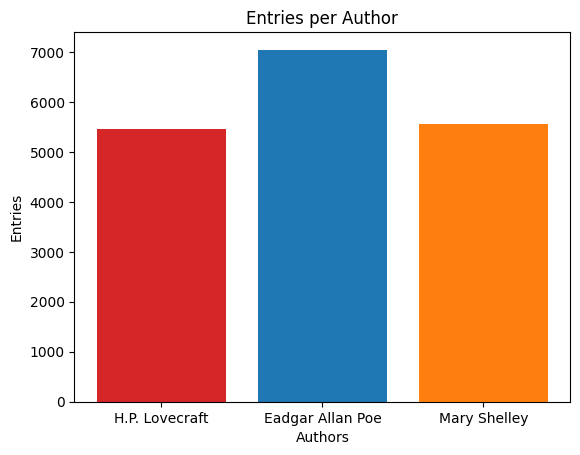

In [226]:
from pyspark.sql import SparkSession
import matplotlib.pyplot as plt

# Grouping by the author shows that there is some texts with no authors. We'll need to clean that up
print('Data before filtering')
print(df_train.groupBy('author').count())

print(df_train)

# The above print reveals that parsing the CSV has caught some unwated lines of text.
# We can select rows based on the only three available authors to clean up the dataset.
df_train = df_train.filter(df_train.author_short.isin(['EAP', 'HPL', 'MWS']))

# Group all entries by author
print('Data after filtering')
author_counts = df_train.groupBy('author').count()
print(author_counts)

# Collect down the list of authors and counts
authors = author_counts.select('author').rdd.flatMap(lambda x: x).collect()
counts = author_counts.select('count').rdd.flatMap(lambda x: x).collect()

# Build and plot the counts per author
fig, ax = plt.subplots()
ax.bar(authors, counts, label=authors, color=['tab:red', 'tab:blue', 'tab:orange'])
ax.set_title('Entries per Author')
ax.set_ylabel('Entries')
ax.set_xlabel('Authors')
plt.show()

The above graph shows the total number of entries for each author. EAP has the highest amount, therefore our data 
should form predictions better for EAP. MWS is in-between while HPL has the lowest amount. I predict that the models
will tend to predict EAP features better since they is more to train on for that particular author.

## **Task 1**: *Data Preperation*

To prepare the data for our models, we need to first conver the string of tokens into a split array. We can use a Tokenizer for this and create a seperate column
containing the list length of each token row. Since we are using text as our feature, we will need to run it through a Stopwords Remover model. This along with a
list of top 10 stop words will help reduce the dataset into words that can be distinguished amongst each other.

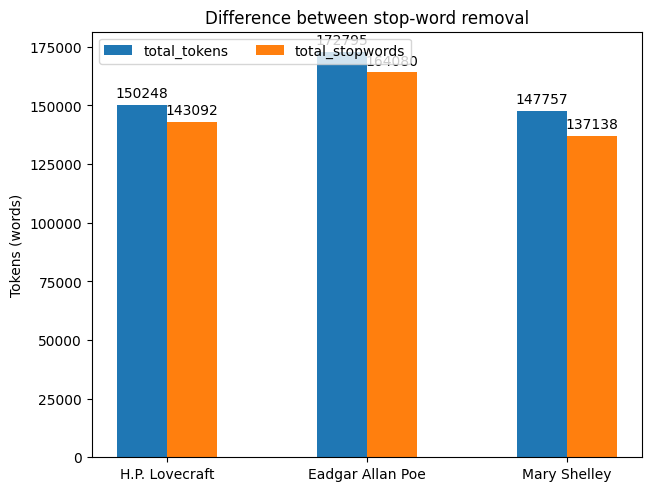

In [227]:
from pyspark.ml.feature import StopWordsRemover, Tokenizer
from pyspark.sql.functions import size, col, sum
import numpy as np

# List of the top ten stopwords
top_ten_stopwords = [
    'i',
    'you',
    'he',
    'she',
    'it',
    'we',
    'they',
    'me',
    'him',
    'her'
]

# Use a tokenizer to split the text into individual tokens. All tokens are then stored into a list
tokenizer = Tokenizer(inputCol="text", outputCol="tokens")

# Transform text into tokens
tokenizer_transformed = tokenizer.transform(df_train)

# Create a new column called tokens_len to store the length of the list of tokens for each entry
df_tokenizer = tokenizer_transformed.withColumn('tokens_len', size(col('tokens')))

# Use a stop words remover to remove common stop words and a list
# including the top 10 stop words
stopwords_remover = StopWordsRemover(
    inputCol="tokens",
    outputCol="filtered_tokens",
    stopWords=top_ten_stopwords
)

# Remove stop words from the dataset
stopwords_remover_transform = stopwords_remover.transform(df_tokenizer)

# Create a new column called tokens_stop_word_len to store the length of the list of tokens for each entry
# after the stop words were removed
df_swr = stopwords_remover_transform.withColumn('tokens_stop_word_len', size(col('filtered_tokens')))

# Calculate tokens_len per author
tokens_len_sum = df_swr.groupBy('author').agg(sum('tokens_len').alias('total_tokens_len'))
# Calculate tokens_stop_word_len per author
tokens_stop_word_len_sum = df_swr.groupBy('author').agg(sum('tokens_stop_word_len').alias('total_stopwords_removed_len'))

# Flatten down to a list
total_tokens_len = tokens_len_sum.select('total_tokens_len').rdd.flatMap(lambda x: x).collect()
total_stopwords_removed_len = tokens_stop_word_len_sum.select('total_stopwords_removed_len').rdd.flatMap(lambda x: x).collect()

# Graph preperation
x = np.arange(len(authors))
width = 0.25
multiplier = 0

# Graph data
lens = {
    'total_tokens': total_tokens_len,
    'total_stopwords': total_stopwords_removed_len
}

# Add bars to graph
fig, ax = plt.subplots(layout='constrained')
for attribute, measurement in lens.items():
    offset = width * multiplier
    rects = ax.bar(x + offset, measurement, width, label=attribute)
    ax.bar_label(rects, padding=3)
    multiplier += 1


# Add some text for labels, title and custom x-axis tick labels, etc.
ax.set_ylabel('Tokens (words)')
ax.set_title('Difference between stop-word removal')
ax.set_xticks(x + (width / 2), authors)
ax.legend(loc='upper left', ncols=3)

# Display Graph
plt.show()


After tokenizing and removing the stop words from the tokenized list, we are still left with EAP having a majority of text associated to it.
The difference in removal size between all authors is rougly ~10,000 words/tokens. This data reduction will help with classifications when
using PCA and K-means, along with predictions when using supervised models such as Logistic Regression and Random Forest Classifier.

## **Task 2**: *Feature Extraction*

To prepare the data for our supervised models, we can run it through several transformations. For our supervised models,
these would be a CountVectorizer to count the frequency of words. We can then pass that through an IF-IDF model to calculate
the term fequency through all documents. We can then normalize the frequencies to a normal range using a Normalizer. Since
the author column is a string, we must use a String Indexer to convert the strings into an index. We can pass all these 
transformations through a pipeline for both our test and training data.

Due to limited hardware resources, the vocabulary size of the Count Vectorizer is set to 500. I have messed with higher values 
such as 1000 and 5000, and I've only seen better results with 1000. 5000 as a vocabulary size started to have worse effects on
K-means clustering, while 1000 did bring it up to as high as 0.3

### Supervised Feature Extraction

In [228]:
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StringIndexer, PCA
from pyspark.sql.functions import col, substring
from pyspark.ml import Pipeline

# Convert the filtered tokens into a vectorizer
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")

# Set the vocab size to 500. This is to keep the resources low for computation
vectorizer.setVocabSize(vocabulary_size)

# Calculate the IDF using the count vectorizer
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

# Normalize the IDF output to it's final features form
normalizer = Normalizer(inputCol="tfidf", outputCol="features")

# Index the authors for the training dataset to integers
string_indexer = StringIndexer(inputCol='author', outputCol='label')

# Create pipeline for training data; process data and select only label and features
pipeline_train = Pipeline(stages=[string_indexer, tokenizer, stopwords_remover, vectorizer, idf, normalizer])
df_train_processed = pipeline_train.fit(df_train).transform(df_train)
df_train_processed = df_train_processed.select(col('label'), col('features')) 

# Create pipeline for test data; process data and select only features
pipeline_test = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, normalizer])
df_test_processed = pipeline_test.fit(df_train).transform(df_train)
df_test_processed = df_test_processed.select(col('features')) 

### Unsupervised Feature Extraction

For unsupervised feature extraction, we can use the PCA transformation to model our data using 3 components. This will be used with
our K-means model.

In [229]:
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, StringIndexer, PCA
from pyspark.sql.functions import col, substring
from pyspark.ml import Pipeline

# Convert the filtered tokens into a vectorizer
vectorizer = CountVectorizer(inputCol="filtered_tokens", outputCol="vectorized_tokens")

# Set the vocab size to 500. This is to keep the resources low for computation
vectorizer.setVocabSize(vocabulary_size)

# Calculate the IDF using the count vectorizer
idf = IDF(inputCol="vectorized_tokens", outputCol="tfidf")

# Reduce to 3 components using PCA
pca = PCA(k=3, inputCol='tfidf', outputCol='features')

# Index the authors for the training dataset to integers
string_indexer = StringIndexer(inputCol='author', outputCol='label')

# Create pipeline for training data; process data and select only label and features
pipeline_train = Pipeline(stages=[string_indexer, tokenizer, stopwords_remover, vectorizer, idf, pca])
df_train_processed_unsupervised = pipeline_train.fit(df_train).transform(df_train)
df_train_processed_unsupervised = df_train_processed.select(col('label'), col('features')) 

# Create pipeline for test data; process data and select only features
pipeline_test = Pipeline(stages=[tokenizer, stopwords_remover, vectorizer, idf, pca])
df_test_processed_unsupervised = pipeline_test.fit(df_train).transform(df_train)
df_test_processed_unsupervised = df_test_processed.select(col('features')) 


## **Task 3**: *Machine Learning*

In [230]:
# Create train test split 70% 30%
df_supervised_train, df_supervised_test = df_train_processed.randomSplit([0.7, 0.3])

## Supervised - Logistic Regression

I used Logistic Regression and Random Forest Classifier for my choice of supervised maching learning models. My assumption with using a random forest classifier
is that the large dataset will benefit when breaking down the model into sub-samples. The logistic regression will be useful since it should be able to predict
with a good accuracy as it tries to fit the best curve amongst the dataset. With a higher vocabulary, we should see a better accuracy for logistic regression as
there will be more data to fit a better curve.

In [231]:
from pyspark.ml.classification import LogisticRegression

# Logistic regression ML
lr = LogisticRegression(featuresCol='features', labelCol='label')

# Train with training data
lr_model = lr.fit(df_supervised_train)

# Test with training data
lr_predictions = lr_model.transform(df_supervised_test)

In [232]:
from pyspark.ml.classification import RandomForestClassifier

# Random Forest Classifier ML
rf = RandomForestClassifier(featuresCol='features', labelCol='label')

# Train with training data
rf_model = rf.fit(df_supervised_train)

# Test with training data
rf_predictions = rf_model.transform(df_supervised_test).select('label', 'prediction')

## Unsupervised

I used PCA and K-Means clustering for my unsupervised analysis. Depending on the randomness of the dataset,
K-means should do fairly well with clustering with relatively common neighbors. With a low vocabulary size, I've
seen great results with a maximum sillhouette score of 0.3. When I would increase the vocab size, the number of 
clusters began to grew at a fast rate. With a vocabulary size of 500 - 1000, the maximum silhouette score was an
average of 0.25. Since the dataset being transformed grows larger as we increase the vocab size, it would make sense 
that more clusters are required to try to form better groupings of the dataset.

In [233]:
from pyspark.ml.clustering import KMeans
from pyspark.ml.evaluation import ClusteringEvaluator

# List to hold evaluation tuples (cluster_size, silhouette_score)
silhouette_scores=[]
kmean_predictions=[]

# Evaluator for K-Means
evaluator = ClusteringEvaluator(predictionCol='prediction',
                                featuresCol='features', \
                                metricName='silhouette', 
                                distanceMeasure='squaredEuclidean')

max_kmeans_cluster_size = 20
# Run K-Means for cluster sizes between 2 and 10
for i in range(2, max_kmeans_cluster_size):
    
    # K-Means algorithm
    kmeans = KMeans(featuresCol='features', 
                    predictionCol='prediction', \
                    k=i)

    # Fit the model with the training data
    model = kmeans.fit(df_train_processed_unsupervised)

    # Make predictions with thw test data
    predictions=model.transform(df_test_processed_unsupervised)
    kmean_predictions.append(predictions)

    # Grab score from evaluator
    score=evaluator.evaluate(predictions)

    # Add score to list for evaluation step
    silhouette_scores.append(score)
    print(f'[k = {i}] Silhouette Score {score}')

[k = 2] Silhouette Score 0.015500043958634965


[k = 3] Silhouette Score 0.009793370536092284


[k = 4] Silhouette Score 0.01664182827862101


[k = 5] Silhouette Score 0.010476626326235758


[k = 6] Silhouette Score 0.015326147375993235


[k = 7] Silhouette Score 0.017440466432490573


[k = 8] Silhouette Score 0.014902429073513739


[k = 9] Silhouette Score 0.008453382777253446


[k = 10] Silhouette Score 0.015302774486514


[k = 11] Silhouette Score 0.01741590250244837


[k = 12] Silhouette Score 0.0031992338478292596


[k = 13] Silhouette Score 0.020778483151350686


[k = 14] Silhouette Score 0.02853003027100968


[k = 15] Silhouette Score 0.02685951041885904


[k = 16] Silhouette Score 0.034612491913622916


[k = 17] Silhouette Score 0.035207023705142344


[k = 18] Silhouette Score 0.033324154795544694


[k = 19] Silhouette Score 0.03144135976896873


## **Task 3**: *Evaluation and Visualization*

/home/christian/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Logistic Regression had an accuracy of 0.6657148296211689


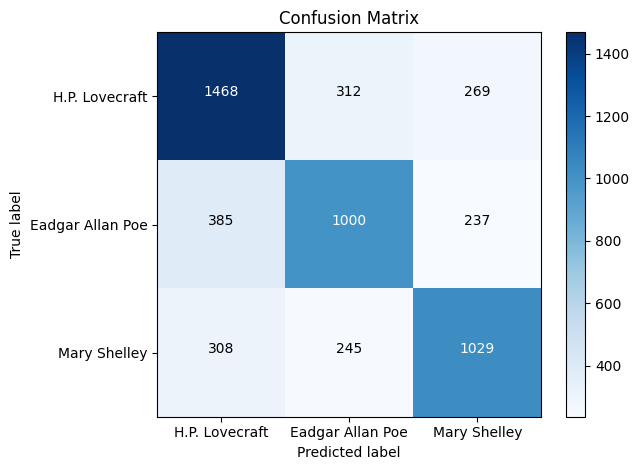

In [234]:
from pyspark.mllib.evaluation import MulticlassMetrics
from sklearn.metrics import confusion_matrix

# Select only prediction and label columns
lr_prediction_label = lr_predictions.select(['prediction','label'])

# Build metrics for logistic regression
metrics = MulticlassMetrics(lr_prediction_label.rdd.map(tuple))

# Create confusion matrix
cnf_matrix = confusion_matrix(lr_predictions.select('label').toPandas(), lr_predictions.select('prediction').toPandas())

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(authors))
plt.xticks(tick_marks, authors)
plt.yticks(tick_marks, authors)

# Label the matrix cells
thresh = cnf_matrix.max() / 2.
for i, j in np.ndindex(cnf_matrix.shape):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

# Display accuracy
print(f'Logistic Regression had an accuracy of {metrics.accuracy}')

The above 3x3 confusion matrix diagram shows how great the logistic regression model did at predicting the authors. With a 70-30 split, MWS had
a high number of correct predictions, followed by EAP and HPL. To increase the accuracy of this model, increasing the vocabulary size of the 
Count Vectorizer would allow for more words to be inserted into the IF-IDF model, producing a better outcome. Overall, it is apparent that
the Logistic Regression model had the better accuracy over the Random Forest Classifier. This model did a great job with calculating the
curve of best possible fit within the data. The false positive predictions for Logistic Regression are very less than that of the Random Forest Classifier.

/home/christian/.local/lib/python3.10/site-packages/pyspark/sql/context.py:157: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


Random Forest Classifier has an accuracy of 0.4890538739767752


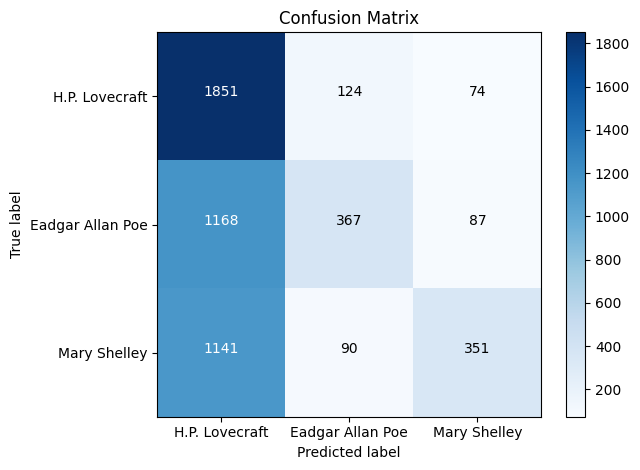

In [235]:
from pyspark.mllib.evaluation import MulticlassMetrics

# Select only the predictions
rf_prediction_label = rf_predictions.select(['prediction','label'])

metrics = MulticlassMetrics(rf_prediction_label.rdd.map(tuple))

cnf_matrix = confusion_matrix(rf_predictions.select('label').toPandas(), rf_predictions.select('prediction').toPandas())

# Plot confusion matrix
plt.imshow(cnf_matrix, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(authors))
plt.xticks(tick_marks, authors)
plt.yticks(tick_marks, authors)

# Label the matrix cells
thresh = cnf_matrix.max() / 2.
for i, j in np.ndindex(cnf_matrix.shape):
    plt.text(j, i, format(cnf_matrix[i, j], 'd'),
             horizontalalignment="center",
             color="white" if cnf_matrix[i, j] > thresh else "black")

# Add axis labels
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.tight_layout()

print(f'Random Forest Classifier has an accuracy of {metrics.accuracy}')

The confusion matrix for the Random Forest Classifier reflects the poor accuracy of the model. The model scored a lower accuracy than the logistic regression.
There were more MWS predictions that were correct, but the other two authors, HPL and EAP, were mostly predicted incorrectly for MWS. The model tended to treat more of 
the texts as possible MWS books, which indicates that the RFC model did a poor job with predicting on subsets of the sampled data. A way to help reduce this 
incorrection may be to increase the vocab size for the Count Vectorizer. Increasing the size will allow for more token variations amongst the entry, giving a better
range of possible values for what author the word can belong to.

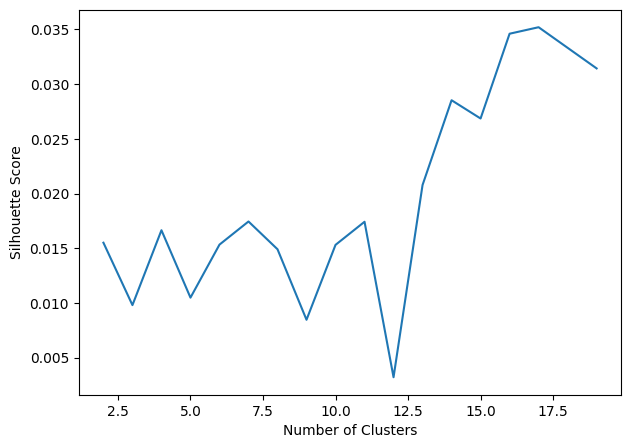

Best cluster size for k-means is 17


In [236]:
# Plot silhouette scores
fig, ax = plt.subplots(1, 1, figsize=(7, 5))

ax.plot(range(2, max_kmeans_cluster_size), silhouette_scores)
ax.set_xlabel('Number of Clusters')
ax.set_ylabel('Silhouette Score')

# Show plot
plt.show()

# Find highest cluster size in silhouette scores.
max_value = max(silhouette_scores)
highest_k = silhouette_scores.index(max_value)
 
print(f'Best cluster size for k-means is {highest_k + 2}')

The above graph shows the different silhouette scores for each of the 18 runs. With a vocab size of 500, the best 
number of clusters hovers around 17. With a value still close to 0, this indicates that there is a lot of overlapping
of our clusters. This means our prediction accuracy will be relatively low, closer to 50%. A way to increase the
silhouette score is to use a larger vocab size and a larger number of clusters. A vocab of size 5000 would provide
more data to cluster, giving a better chance of having like-data neighboring closer together.